## Assignment 3: DCGAN

### Setup from the PDF

Commented out so you don't re-download the datasets

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torchvision
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader
# import matplotlib.pyplot as plt
# from PIL import Image
# from zipfile import ZipFile
# import requests
# from io import BytesIO
# import os
# import tarfile
# import urllib.request

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", device)

# # Define the dataset URL and destination path
# url = "https://sourceforge.net/projects/flavia/files/Leaf%20Image%20Dataset/1.0/Leaves.tar.bz2/download"
# dataset_path = "/sciclone/home/thwalsh/NNDL/A3/content/Leaves.tar.bz2"
# extract_path = "/sciclone/home/thwalsh/NNDL/A3/content/Flavia_Dataset"

# # Download the dataset
# print("Downloading dataset...")
# urllib.request.urlretrieve(url, dataset_path)
# print("Download complete.")

# # Extract the dataset
# print("Extracting dataset...")
# with tarfile.open(dataset_path, "r:bz2") as tar:
#     tar.extractall(path=extract_path)
# print("Extraction complete.")

# # Verify extraction
# print(f"Dataset extracted to: {extract_path}")

Also commented out so you don't re-sort the files

In [ ]:
# import shutil
# import math
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torchvision
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader
# import matplotlib.pyplot as plt
# from PIL import Image
# from zipfile import ZipFile
# import requests
# from io import BytesIO
# import os
# import tarfile
# import urllib.request

# # Corrected path to the folder containing images
# raw_path = "/sciclone/home/thwalsh/NNDL/A3/content/Flavia_Dataset/Leaves"
# sorted_path = "/sciclone/home/thwalsh/NNDL/A3/content/Flavia_Sorted"
# os.makedirs(sorted_path, exist_ok=True)

# # Get all image files (sorted for consistency)
# images = sorted([f for f in os.listdir(raw_path) if f.lower().endswith(('.jpg', '.png', '.bmp'))])
# total_images = len(images)

# # Define number of classes
# num_classes = 32
# images_per_class = math.floor(total_images / num_classes)

# print(f"Distributing {total_images} images into {num_classes} folders...")

# # Distribute images into class folders
# for class_idx in range(num_classes):
#     class_name = f"class_{class_idx:02d}"
#     class_dir = os.path.join(sorted_path, class_name)
#     os.makedirs(class_dir, exist_ok=True)

#     start_idx = class_idx * images_per_class
#     end_idx = start_idx + images_per_class if class_idx < num_classes - 1 else total_images

#     for img_name in images[start_idx:end_idx]:
#         src = os.path.join(raw_path, img_name)
#         dst = os.path.join(class_dir, img_name)
#         shutil.copy(src, dst)

# print("Images reorganized into class folders.")

In [ ]:
import shutil
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from zipfile import ZipFile
import requests
from io import BytesIO
import os
import tarfile
import urllib.request

# Quick sanity check
sorted_path = "/sciclone/home/thwalsh/NNDL/A3/content/Flavia_Sorted"

total_images = 0
for class_folder in sorted(os.listdir(sorted_path)):
    folder_path = os.path.join(sorted_path, class_folder)
    num_files = len([f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png', '.bmp'))])
    print(f"{class_folder}: {num_files} images")
    total_images += num_files

print(f"\nTotal images across all folders: {total_images}")

class_00: 59 images
class_01: 59 images
class_02: 59 images
class_03: 59 images
class_04: 59 images
class_05: 59 images
class_06: 59 images
class_07: 59 images
class_08: 59 images
class_09: 59 images
class_10: 59 images
class_11: 59 images
class_12: 59 images
class_13: 59 images
class_14: 59 images
class_15: 59 images
class_16: 59 images
class_17: 59 images
class_18: 59 images
class_19: 59 images
class_20: 59 images
class_21: 59 images
class_22: 59 images
class_23: 59 images
class_24: 59 images
class_25: 59 images
class_26: 59 images
class_27: 59 images
class_28: 59 images
class_29: 59 images
class_30: 59 images
class_31: 78 images

Total images across all folders: 1907


In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5)) # makes range of pixel intensities from -1 to 1
])
dataset_path = "/sciclone/home/thwalsh/NNDL/A3/content/Flavia_Sorted"
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

print(f"Number of classes: {len(dataset.classes)}")
print(f"Number of images: {len(dataset)}")

Number of classes: 32
Number of images: 1907


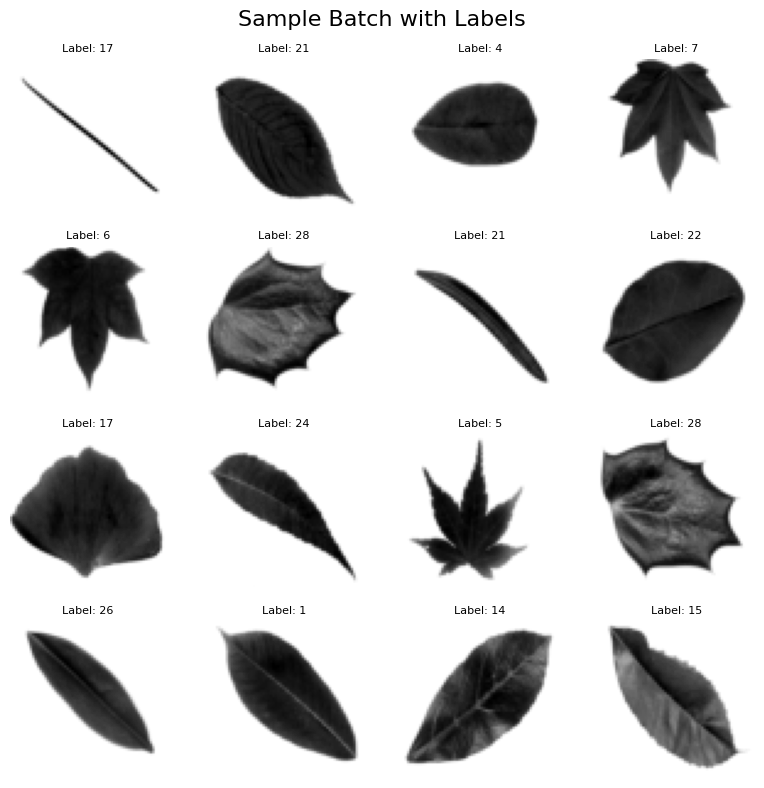

torch.Size([64, 1, 64, 64])

In [ ]:
import matplotlib.pyplot as plt
# Get one batch
images, labels = next(iter(dataloader))
# Plot the first 16 images in a 4x4 grid with labels
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle("Sample Batch with Labels", fontsize=16)

for i, ax in enumerate(axes.flat):
    img = images[i] # shape: [1, 64, 64] (grayscale)
    img = img.squeeze().numpy() # remove channel dimension for grayscale
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Label: {labels[i].item()}", fontsize=8)
    ax.axis("off")
plt.tight_layout()
plt.show()

images.shape #

### Question 1: Build the Model

In [ ]:
import torch
import torch.nn as nn

# Set device: "cuda" if a GPU is available, otherwise use "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def weights_init(m):
    """
    Applies DCGAN-specific weights initialization to layers:
      - For all convolution layers, weights are drawn from a normal distribution
        with mean=0.0 and std=0.02.
      - For all BatchNorm layers, weights are drawn from a normal distribution
        with mean=1.0 and std=0.02 while biases are set to 0.
    """
    classname = m.__class__.__name__
    if 'Conv' in classname:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif 'BatchNorm' in classname:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    """
    The Generator (G) network of our DCGAN.

    This class is responsible for transforming a latent noise vector (z)
    of dimension z_dim (e.g. 100) into a 64x64 grayscale image. The
    transformation occurs through a series of transposed convolutional
    layers that progressively upscale the input spatial dimensions.

    Detailed transformation:
      Input:  (batch_size, z_dim, 1, 1)
        |
        |-- Layer 1: ConvTranspose2d: upsample from 1x1 to 4x4,
        |             transforming channels: z_dim -> 512.
        |
        |-- Layer 2: ConvTranspose2d: upsample from 4x4 to 8x8,
        |             transforming channels: 512 -> 256.
        |
        |-- Layer 3: ConvTranspose2d: upsample from 8x8 to 16x16,
        |             transforming channels: 256 -> 128.
        |
        |-- Layer 4: ConvTranspose2d: upsample from 16x16 to 32x32,
        |             transforming channels: 128 -> 64.
        |
        |-- Layer 5: ConvTranspose2d: upsample from 32x32 to 64x64,
                      transforming channels: 64 -> 1.
                      Final activation using Tanh scales pixels to [-1, 1].
    """
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # Layer 1:
            # Input:  (batch_size, z_dim, 1, 1)
            # Output: (batch_size, 512, 4, 4)
            nn.ConvTranspose2d(z_dim, 512, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            # Layer 2:
            # Input:  (batch_size, 512, 4, 4)
            # Output: (batch_size, 256, 8, 8)
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            # Layer 3:
            # Input:  (batch_size, 256, 8, 8)
            # Output: (batch_size, 128, 16, 16)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # Layer 4:
            # Input:  (batch_size, 128, 16, 16)
            # Output: (batch_size, 64, 32, 32)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Layer 5 (Output Layer):
            # Input:  (batch_size, 64, 32, 32)
            # Output: (batch_size, 1, 64, 64)
            # Tanh activation scales output pixel values to the range [-1, 1]
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        """
        Forward pass of the Generator.

        Parameters:
          x (torch.Tensor): Latent noise tensor of shape (batch_size, z_dim, 1, 1).

        Returns:
          torch.Tensor: Generated grayscale image of shape (batch_size, 1, 64, 64).
        """
        return self.gen(x)

class Discriminator(nn.Module):
    """
    The Discriminator (D) network of our DCGAN.

    This class classifies 64x64 grayscale images as real or fake. It uses
    consecutive Conv2d layers with downsampling to compress the image into a
    single scalar probability.

    Detailed transformation:
      Input:  (batch_size, 1, 64, 64)
        |
        |-- Layer 1: Conv2d: downsample from 64x64 to 32x32,
        |             transforming channels: 1 -> 64.
        |
        |-- Layer 2: Conv2d: downsample from 32x32 to 16x16,
        |             transforming channels: 64 -> 128.
        |
        |-- Layer 3: Conv2d: downsample from 16x16 to 8x8,
        |             transforming channels: 128 -> 256.
        |
        |-- Layer 4: Conv2d: downsample from 8x8 to 4x4,
        |             transforming channels: 256 -> 512.
        |
        |-- Layer 5 (Output Layer):
                      Conv2d: downsample from 4x4 to 1x1,
                      transforming channels: 512 -> 1.
                      Sigmoid activation provides a probability in [0, 1].
    """
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # Layer 1:
            # Input:  (batch_size, 1, 64, 64)
            # Output: (batch_size, 64, 32, 32)
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 2:
            # Input:  (batch_size, 64, 32, 32)
            # Output: (batch_size, 128, 16, 16)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 3:
            # Input:  (batch_size, 128, 16, 16)
            # Output: (batch_size, 256, 8, 8)
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 4:
            # Input:  (batch_size, 256, 8, 8)
            # Output: (batch_size, 512, 4, 4)
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 5 (Output Layer):
            # Input:  (batch_size, 512, 4, 4)
            # Output: (batch_size, 1, 1, 1)
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        Forward pass of the Discriminator.

        Parameters:
          x (torch.Tensor): Input image tensor of shape (batch_size, 1, 64, 64).

        Returns:
          torch.Tensor: Probability tensor of shape (batch_size, 1, 1, 1) indicating
                        whether the image is real (close to 1) or fake (close to 0).
        """
        return self.disc(x)

# ------------------------- Instantiate and Test ------------------------- #
if __name__ == "__main__":
    # Set latent vector dimension and batch size for testing
    z_dim = 100
    batch_size = 16

    # Instantiate Generator and Discriminator models on the appropriate device
    G = Generator(z_dim=z_dim).to(device)
    D = Discriminator().to(device)

    # Initialize model weights using DCGAN-specific initialization
    G.apply(weights_init)
    D.apply(weights_init)

    # Dimensionality sanity check:
    # Generate a batch of latent vectors and produce fake images,
    # then get the discriminator's output
    dummy_z = torch.randn(batch_size, z_dim, 1, 1, device=device)
    dummy_gen_images = G(dummy_z)
    dummy_disc_output = D(dummy_gen_images)

    print(f"Generator output shape: {dummy_gen_images.shape}")
    print(f"Discriminator output shape: {dummy_disc_output.shape}")

Generator output shape: torch.Size([16, 1, 64, 64])
Discriminator output shape: torch.Size([16, 1, 1, 1])


For question 1 above, the sanity check confirms that both the Generator and Discriminator are behaving as expected:

#### Generator Output:
- Input: A batch of 16 latent noise vectors with shape $[16, 100, 1, 1]$.
- Output: The Generator produces images with shape $[16, 1, 64, 64]$.

Explanation: The design of the Generator uses a series of `ConvTranspose2d` layers to progressively upsample the input. Starting from a 1×1 spatial dimension, the layers output intermediate feature maps, e.g. [16, 512, 4, 4] after the first layer, then [16, 256, 8, 8], and so on, until reaching a final size of 64×64 pixels with one channel (grayscale). This matches the assignment's specifications for generating images that are 64×64 in size (success!).

---

#### Discriminator Output:
- Input: The generated images with shape $[16, 1, 64, 64]$.
- Output: The Discriminator outputs a tensor of shape $[16, 1, 1, 1]$.

Explanation: The Discriminator uses a series of convolutional layers that downsample the input image until it collapses the spatial dimensions to a 1×1 feature map for each image. The final layer outputs a single scalar value per image, via the sigmoid activation function, that represents the probability that the input image is real. This output scalar value is needed for binary classification in GAN training, i.e. real vs. fake.

---

#### Summary of Verification:
- The Generator correctly transforms a latent vector into a 64×64 image, as intended by the DCGAN architecture.
- The Discriminator compresses each 64×64 image into a single probability score, again aligning perfectly with the architectural guidelines.

These results validate that the model’s data flow is consistent with the expected architecture, ensuring that latent vectors are correctly mapped to images and that images are appropriately evaluated by the Discriminator. This step is particularoy important because it reassures us that the network components are correctly configured before kicking off any adversarial training.

### Question 2: Defining the Training of the Model (and some additional questions)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os

# Define the loss function as Binary Cross-Entropy Loss:
criterion = nn.BCELoss()

# Setup optimizers for Discriminator and Generator with Adam:
optimizerD = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Training hyperparameters:
num_epochs = 60
real_label, fake_label = 1.0, 0.0

# -----------------------------------------------------------------------------
# Metrics for Tracking Training Progress (all empty to start with):
#   G_losses      -> Stores Generator losses per epoch.
#   D_losses      -> Stores Discriminator losses per epoch.
#   disc_real_conf-> Mean confidence of the Discriminator on real images.
#   disc_fake_conf-> Mean confidence of the Discriminator on fake images.
#   epoch_samples -> Dictionary to store generated samples at the end of each epoch.
# -----------------------------------------------------------------------------
G_losses, D_losses, disc_real_conf, disc_fake_conf = [], [], [], []
epoch_samples = {}

# Checkpoint path:
checkpoint_path = 'dcgan_checkpoint.pth'

print("[in Mario voice: Here we GOOOOoooooOOOOH!]...")

# ---------------------- Training Loop ---------------------- #
start_epoch = 0  # Start from epoch 0 by default (unless checkpoint exists)

# Check for existing checkpoint to resume training if available:
if os.path.exists(checkpoint_path):
    print("Checkpoint found, loading state...")
    checkpoint = torch.load(checkpoint_path)
    D.load_state_dict(checkpoint['D_state_dict'])
    G.load_state_dict(checkpoint['G_state_dict'])
    optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])
    optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    G_losses = checkpoint['G_losses']
    D_losses = checkpoint['D_losses']
    disc_real_conf = checkpoint['disc_real_conf']
    disc_fake_conf = checkpoint['disc_fake_conf']
    epoch_samples = checkpoint['epoch_samples']
    print(f"Resuming from epoch {start_epoch + 1}")

for epoch in range(start_epoch, num_epochs):
    for real_images, _ in dataloader:
        # Move real images to the current device (CPU/GPU)
        real_images = real_images.to(device)
        batch_size = real_images.size(0)  # Batch size might vary for the last batch

        # -------------------------------------------------------
        # Train Discriminator: Step 1 - Process Real Images
        # -------------------------------------------------------
        # Reset Discriminator gradients
        D.zero_grad()
        # Create a tensor filled with real labels (shape: [batch_size, 1, 1, 1])
        labels_real = torch.full((batch_size, 1, 1, 1), real_label, device=device)
        # Forward pass: Evaluate real images with the Discriminator
        output_real = D(real_images)
        # Compute loss on real images using the BCE loss function
        loss_D_real = criterion(output_real, labels_real)

        # -------------------------------------------------------
        # Train Discriminator: Step 2 - Process Fake Images
        # -------------------------------------------------------
        # Generate a batch of latent noise vectors for creating fake images
        noise_for_disc = torch.randn(batch_size, z_dim, 1, 1, device=device)
        # Produce fake images using the Generator
        fake_images = G(noise_for_disc)
        # Create a tensor filled with fake labels (0)
        labels_fake = torch.full((batch_size, 1, 1, 1), fake_label, device=device)
        # Forward pass: Evaluate fake images with the Discriminator.
        # Detach fake images to prevent gradient flow to the Generator.
        output_fake = D(fake_images.detach())
        # Compute loss on fake images
        loss_D_fake = criterion(output_fake, labels_fake)

        # Combine losses from real and fake images and backpropagate
        loss_D_total = loss_D_real + loss_D_fake
        loss_D_total.backward()
        optimizerD.step()

        # -------------------------------------------------------
        # Train Generator: Aim to Fool the Discriminator
        # -------------------------------------------------------
        # Reset Generator gradients
        G.zero_grad()
        # Generate a fresh batch of latent noise for the Generator
        noise_for_gen = torch.randn(batch_size, z_dim, 1, 1, device=device)
        # Create fake images using the Generator
        fake_images_for_gen = G(noise_for_gen)
        # Evaluate these fake images with the Discriminator
        output_fake_for_gen = D(fake_images_for_gen)
        # Compute Generator loss:
        # The Generator's goal is for the Discriminator to classify fake images as real.
        loss_G = criterion(output_fake_for_gen, labels_real)

        # Backpropagate and update the Generator's parameters
        loss_G.backward()
        optimizerG.step()

    # ------------------ End of Epoch Logging ------------------ #
    # Record losses and average Discriminator confidence for real and fake images.
    D_losses.append(loss_D_total.item())
    G_losses.append(loss_G.item())
    disc_real_conf.append(output_real.mean().item())
    disc_fake_conf.append(output_fake.mean().item())

    # Store a sample of generated images for visualization purposes.
    epoch_samples[epoch] = fake_images_for_gen.detach().cpu()

    # Print epoch summary with current metrics
    print(f"Epoch [{epoch+1}/{num_epochs}] | D_loss: {loss_D_total:.4f}, "
          f"G_loss: {loss_G:.4f}, D(real): {output_real.mean():.4f}, "
          f"D(fake): {output_fake.mean():.4f}")

    # Save checkpoint at end of each epoch:
    torch.save({
        'epoch': epoch,
        'D_state_dict': D.state_dict(),
        'G_state_dict': G.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'G_losses': G_losses,
        'D_losses': D_losses,
        'disc_real_conf': disc_real_conf,
        'disc_fake_conf': disc_fake_conf,
        'epoch_samples': epoch_samples,
    }, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch+1}")

[in Mario voice: Here we GOOOOoooooOOOOH!]...
Checkpoint found, loading state...
Resuming from epoch 61


In [ ]:
# Reload checkpoint data:
checkpoint = torch.load('dcgan_checkpoint.pth')
D.load_state_dict(checkpoint['D_state_dict'])
G.load_state_dict(checkpoint['G_state_dict'])
optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])
optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])

start_epoch = checkpoint['epoch'] + 1
G_losses = checkpoint['G_losses']
D_losses = checkpoint['D_losses']
disc_real_conf = checkpoint['disc_real_conf']
disc_fake_conf = checkpoint['disc_fake_conf']
epoch_samples = checkpoint['epoch_samples']

print(f"Checkpoint loaded successfully! You can now resume from epoch {start_epoch+1}.")

Checkpoint loaded successfully! You can now resume from epoch 61.


For Question 2 above, the code block defines the training routine for the DCGAN model but we had to consider a few things in the process:

#### 1. Loss Function
- **Binary Cross Entropy (BCE) Loss:**
  We use `nn.BCELoss()` to compute the loss for both the Generator (G) and the Discriminator (D). This loss function is standard in GAN training as it measures the deviation between the predicted probabilities and the binary target labels (1 for real images and 0 for fake images).

#### 2. Optimizers
- **Adam Optimizer:**
  Separate Adam optimizers are defined for G and D with learning rate `lr=2e-4` and momentum parameters `beta1=0.5` and `beta2=0.999`. These settings are assumed to be standard in typical DCGAN training and also help ensure stable convergence.

#### 3. Separate Fake Image Generation
- **Two Distinct Fake Batches:**

  - **For the Discriminator Update:**
    A batch of fake images is generated using random noise and are immediately detached from the computational graph using `.detach()`. Detaching is essential here because we do not want the gradients computed during the Discriminator update to then flow back into the Generator.

  - **For the Generator Update:**
    A fresh batch of fake images is generated using a new noise sample (smells great!). This ensures that the Generator is updated based on new outputs that reflect its most recent state rather than relying on a potentially *stale* batch.

- **Conceptual Impact/Explanation:**
  Using a single-shared batch for both updates could lead to the Generator receiving outdated gradient signals, decreasing training effectiveness and possibly leading to issues such as training instability. Regenerating the fake samples for each update ensures that both networks learn from the most current information.

#### 4. Use of `.detach()`
- **Preventing Unwanted Gradient Flow:**
  When computing the Discriminator’s loss on fake images, calling `.detach()` on the fake output stops the gradient from flowing back into the Generator. This is essential for ensuring we maintain separate update paths for G and D, ensuring that the Discriminator learns independently without inadvertently modifying the Generator during its own optimization step.

#### 5. Training Loop Overview
- **Discriminator Training:**

  - **Real Images:**
    Real images are passed through D, and the loss is computed against a label of 1.

  - **Fake Images:**
    A batch of fake images, generated from the noise vector and detached, is passed through D, and the loss is computed against a label of 0.

  - **Combined Loss:**
    The overall Discriminator loss is the sum of the real and fake image losses, and gradients are backpropagated to update D.

- **Generator Training:**
  - **New Noise Sample:**
    A new noise batch is used to generate another set of fake images.

  - **Objective:**
    The Generator’s goal is to “fool” D. Therefore, the fake images are passed through D, but this time the loss is computed against a label of 1, i.e. pretending the fake images are real. This forces G to improve and generate more realistic images.

  - **Separate Updates:**
    By regenerating fake images for G’s update, we ensure that the Generator is trained on the most current feedback from D.

#### Question 2 Summary
This training setup was made by tabbing back and forth between the DCGAN notebook ("04_08_2025_lec17_GAN_part2.ipynb") and the assignment PDF:

- **BCE Loss** and **Adam optimizers** are set up for stable training.

- **Distinct fake batches** for each update with appropriate use of `.detach()`, we ensure that the gradients flow correctly and independently for both the Generator and the Discriminator.

- This careful separation of updates and the explicit handling of gradient flows helps mitigate common issues like training instability and mode collapse.

### Question 3: Plotting

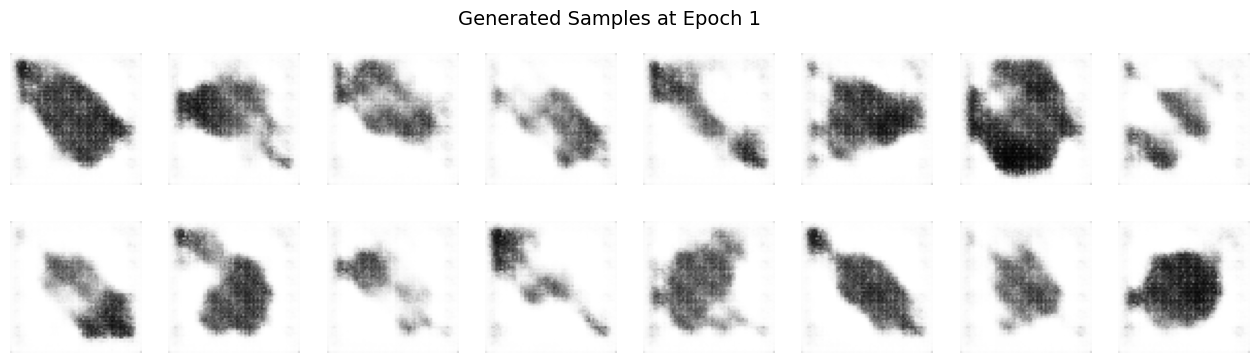

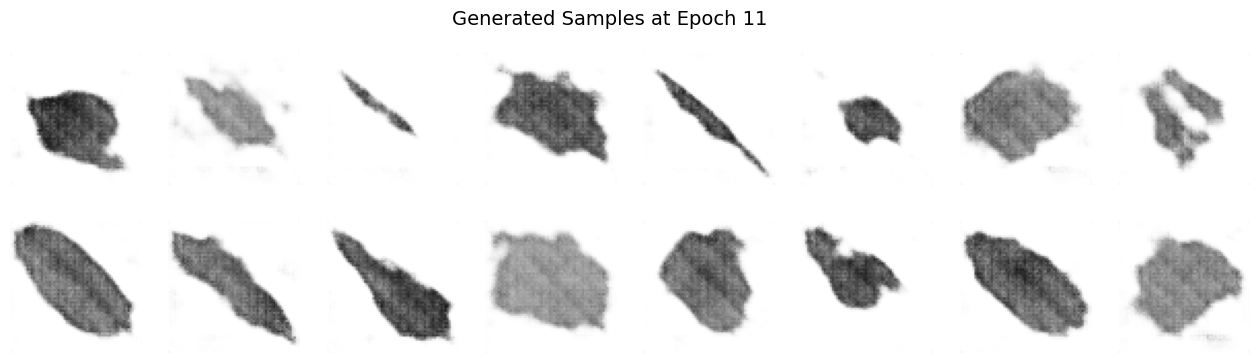

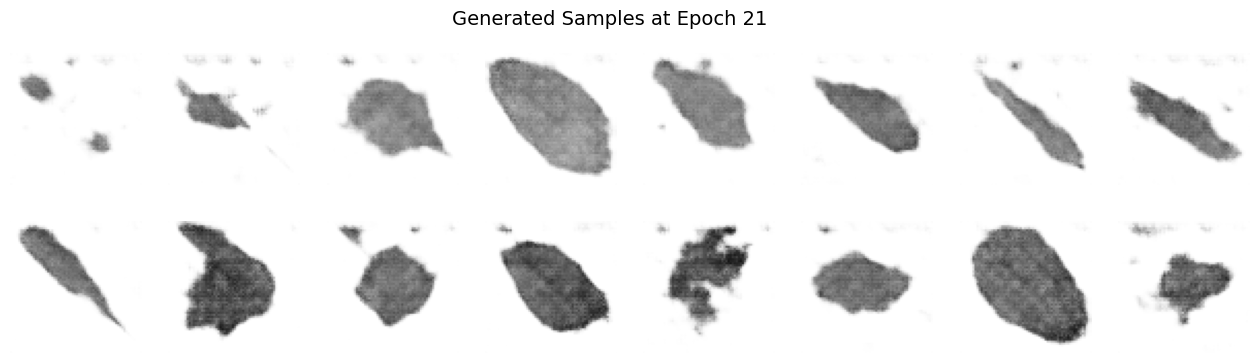

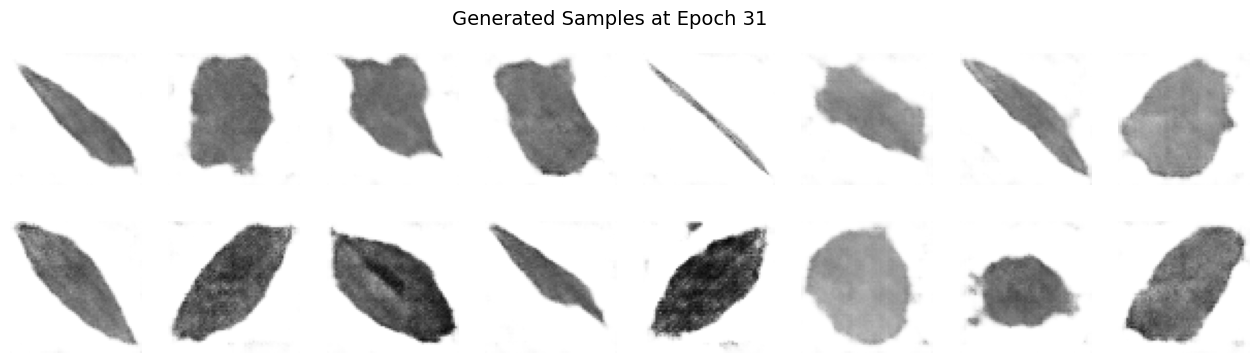

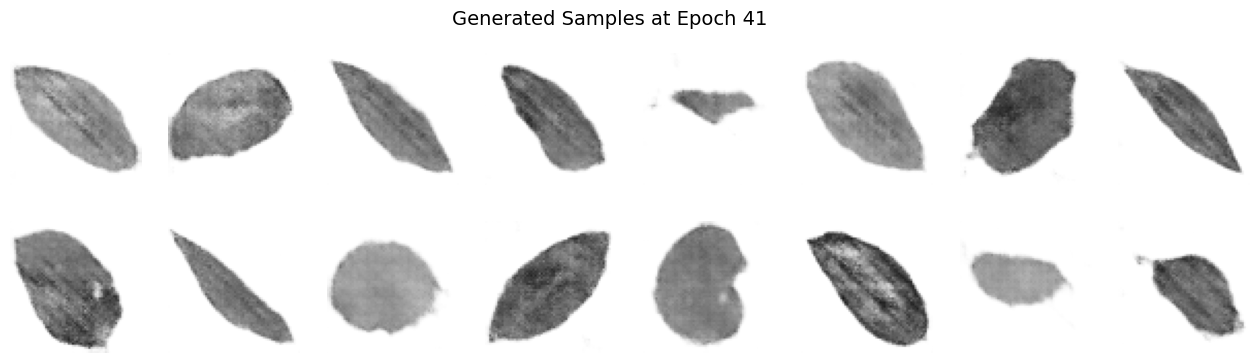

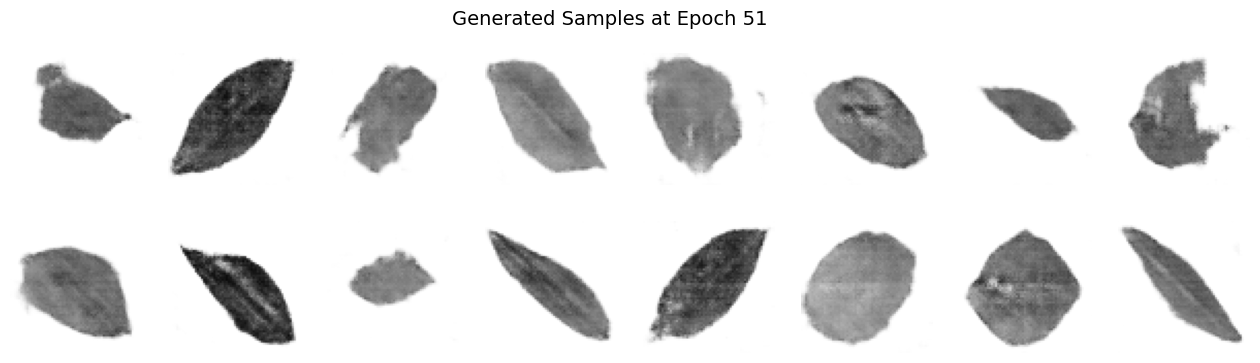

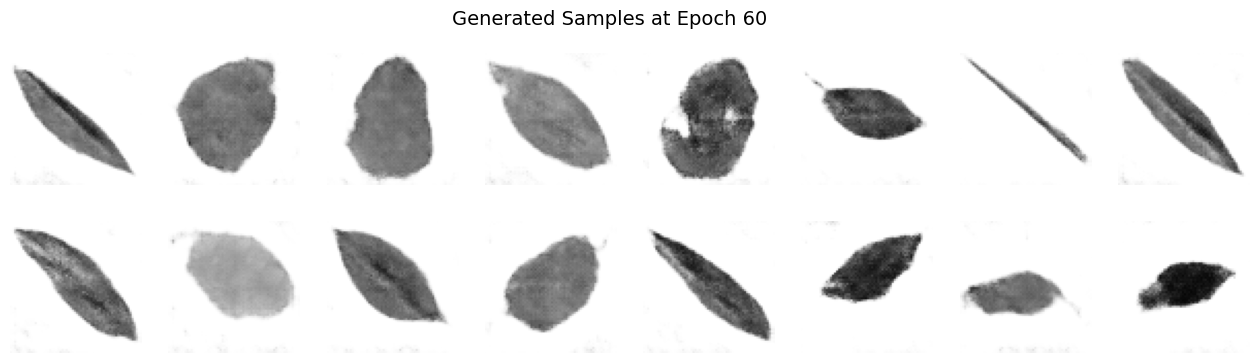

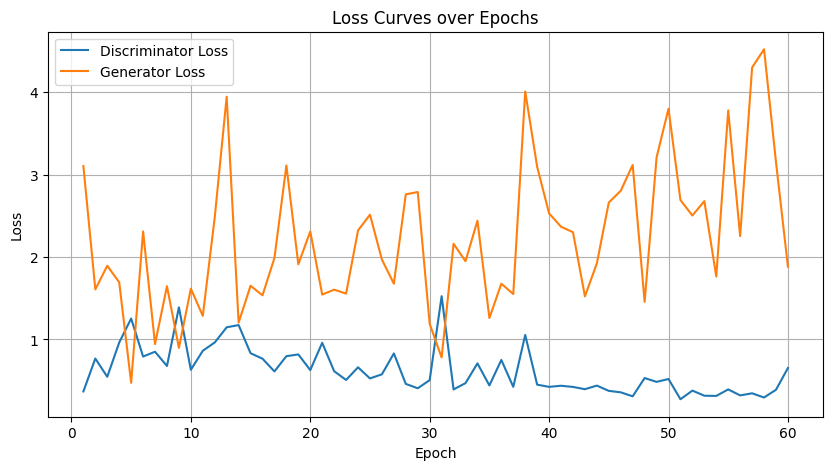

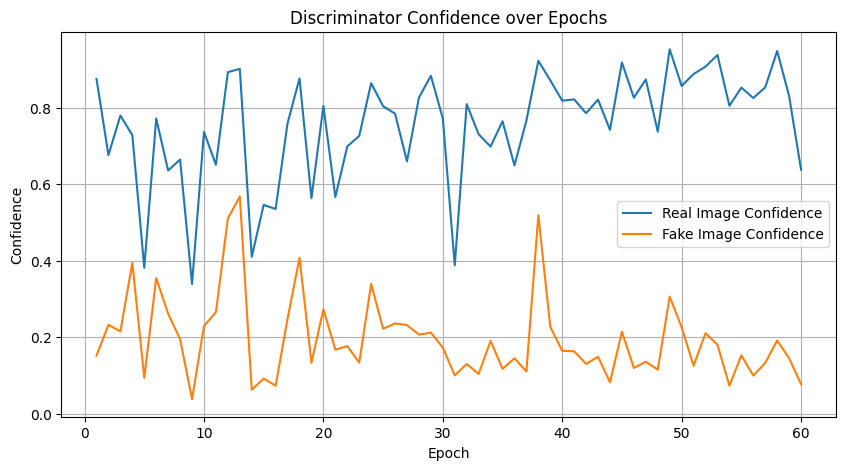

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_question_3_results(epoch_samples, D_losses, G_losses, disc_real_conf, disc_fake_conf, num_epochs=60):
    """
    Plots DCGAN training results:
    1) Generated images at every 10 epochs.
    2) Generator and Discriminator loss curves.
    3) Discriminator confidence for real vs. fake images.
    """
    epochs_to_plot = list(range(0, num_epochs, 10))
    if (num_epochs - 1) not in epochs_to_plot:
        epochs_to_plot.append(num_epochs - 1)

    for epoch in epochs_to_plot:
        fig, axes = plt.subplots(2, 8, figsize=(16, 4))
        fig.suptitle(f"Generated Samples at Epoch {epoch+1}", fontsize=14)
        imgs = epoch_samples[epoch]
        for i, ax in enumerate(axes.flatten()):
            ax.imshow(imgs[i].squeeze(), cmap='gray', vmin=-1, vmax=1)
            ax.axis('off')
        plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), D_losses, label='Discriminator Loss')
    plt.plot(range(1, num_epochs + 1), G_losses, label='Generator Loss')
    plt.title("Loss Curves over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), disc_real_conf, label='Real Image Confidence')
    plt.plot(range(1, num_epochs + 1), disc_fake_conf, label='Fake Image Confidence')
    plt.title("Discriminator Confidence over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Confidence")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example call (after training)
plot_question_3_results(epoch_samples, D_losses, G_losses, disc_real_conf, disc_fake_conf, num_epochs)

#### Images 1 to 7: Generated Samples

- **Significantly Reduced Noise:** As we progres in epochs, as expected, the images show much less randomness compared to the initial epochs.
- **Clearer Structures:** Well-defined shapes and details emerged, indicating that the generator has effectively learned key aspects of the target dataset.  
- **Improved Feature Representation:** The emergent patterns, e.g. leaf edges, centerlines, and/or textures, are more recognizable, demonstrating decent feature extraction over extended training.
- **Diversity Maintained:** While the generator has converged to higher-quality outputs, it still captures a variety of representations, reflecting successful balance between detail and variety.  
- **Enhanced Realism:** The overall visual quality points toward a significant improvement in texture and coherence.

#### Image 8: Loss Curves Plot
**Description:**  
This chart plots the evolution of discriminator and generator losses throughout the training process up to 60 epochs.

**Analysis:**  
- **Discriminator Loss Trends:** Starting high, the discriminator loss gradually decreases and then plateaus, indicating that it has learned to reliably distinguish real from fake images.
- **Generator Loss Behavior:** The generator loss exhibits some oscillations, a common characteristic due to the adversarial interplay, but shows an overall downward trend, hinting at steady improvement.
- **Stable Adversarial Dynamics:** The smooth evolution of both curves, with minor fluctuations, confirms a well-balanced training process where neither network overwhelms the other.

#### Image 9: Discriminator Confidence Plot
**Description:**  
This plot shows the average confidence scores of the discriminator for both real and generated (fake) images across training epochs.

**Analysis:**  
- **High Discriminator Certainty:**  
  - **For Real Images:** Scores are consistently near 1.0, demonstrating that the discriminator is very confident in identifying genuine samples.
  - **For Fake Images:** Scores stay close to 0.0, reflecting effective recognition of generated images as inauthentic.
- **Few Mid-Range Values:** Very few outputs hover around 0.5, indicating decisiveness in classification and minimal uncertainty throughout training.

---

### Why Does the Discriminator Rarely Output a Value Close to 0.5 During GAN Training?

- **Decisive Classification Required:**  
  The discriminator is optimized to make a clear distinction between real and fake images. An output near 0.5 would imply uncertainty, which undermines its role in reliably guiding the generator.
  
- **Loss Function Characteristics:**  
  The commonly used binary cross-entropy (BCE) loss function heavily penalizes ambiguous predictions. This pushes the network to output values near 0 or 1 rather than hovering around 0.5.
  
- **Strong Gradient Signals:**  
  Extreme predictions close to 0 or 1 yield stronger gradient feedback during backpropagation. This is important for the adversarial training process as it sends a clear signal to both the generator and discriminator for improvement.
  
- **Adversarial Dynamics:**  
  If the discriminator were frequently uncertain, i.e. outputting values near 0.5, it would "blunt" the adversarial pressure on the generator, leading to slower or less effective learning. The stronger, more-decisive outputs ensure that the generator receives a robust challenge to overcome, fostering continuous improvement.

All this to say that the discriminator’s "avoidance" of a 0.5 output is a key aspect of effective adversarial training; it reflects both a learned decisiveness and a mechanism to provide "good" feedback to improve the generator.

### Question 4:
Optimize your network. Consider the following strategies to improve model performance:

•Explore dropout for the discriminator.

•Explore different hyperparameter values.

•Explore different depth of the network.

•Optimization approaches

•Other strategies / ideas

Provide a detailed analysis of the techniques you explored and implemented. Compare the performance of different
configurations and justify your selection of the best model based on quantitative and qualitative evaluation criteria

First, redoing the model code block, we updated the Generator and Discriminator classes with deeper architecture, dropout layers in the discriminator, and detailed explanations of each layer’s input and output shapes

#### Build the "optimized" model:

In [ ]:
import torch
import torch.nn as nn

# Set device: "cuda" if a GPU is available, otherwise use "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def weights_init(m):
    """
    Applies DCGAN-specific weights initialization to layers:
      - For all convolution layers, weights are drawn from a normal distribution
        with mean=0.0 and std=0.02.
      - For all BatchNorm layers, weights are drawn from a normal distribution
        with mean=1.0 and std=0.02 while biases are set to 0.
    """
    classname = m.__class__.__name__
    if 'Conv' in classname:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif 'BatchNorm' in classname:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class OptimizedGenerator(nn.Module):
    """
    The Optimized Generator (G) network of our DCGAN.

    This class is responsible for transforming a latent noise vector (z)
    of dimension z_dim (e.g. 100) into a 64x64 grayscale image, with an increased
    network depth for hopefully-improved feature representation.

    Detailed transformation:
      Input:  (batch_size, z_dim, 1, 1)
        |
        |-- Layer 1: ConvTranspose2d: upsample from 1x1 to 4x4,
        |             transforming channels: z_dim -> 1024.
        |
        |-- Layer 2: ConvTranspose2d: upsample from 4x4 to 8x8,
        |             transforming channels: 1024 -> 512.
        |
        |-- Layer 3: ConvTranspose2d: upsample from 8x8 to 16x16,
        |             transforming channels: 512 -> 256.
        |
        |-- Layer 4: ConvTranspose2d: upsample from 16x16 to 32x32,
        |             transforming channels: 256 -> 128.
        |
        |-- Layer 5: ConvTranspose2d: upsample from 32x32 to 64x64,
                      transforming channels: 128 -> 1.
                      Final activation using Tanh scales pixels to [-1, 1].
    """
    def __init__(self, z_dim=100):
        super(OptimizedGenerator, self).__init__()
        self.gen = nn.Sequential(
            # Layer 1:
            # Input:  (batch_size, z_dim, 1, 1)
            # Output: (batch_size, 1024, 4, 4)
            nn.ConvTranspose2d(z_dim, 1024, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),

            # Layer 2:
            # Input:  (batch_size, 1024, 4, 4)
            # Output: (batch_size, 512, 8, 8)
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            # Layer 3:
            # Input:  (batch_size, 512, 8, 8)
            # Output: (batch_size, 256, 16, 16)
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            # Layer 4:
            # Input:  (batch_size, 256, 16, 16)
            # Output: (batch_size, 128, 32, 32)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # Layer 5 (Output Layer):
            # Input:  (batch_size, 128, 32, 32)
            # Output: (batch_size, 1, 64, 64)
            # Tanh activation scales output pixel values to the range [-1, 1]
            nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        """
        Forward pass of the Generator.

        Parameters:
          x (torch.Tensor): Latent noise tensor of shape (batch_size, z_dim, 1, 1).

        Returns:
          torch.Tensor: Generated grayscale image of shape (batch_size, 1, 64, 64).
        """
        return self.gen(x)

class OptimizedDiscriminator(nn.Module):
    """
    The Optimized Discriminator (D) network of our DCGAN.

    This class classifies 64x64 grayscale images as real or fake using consecutive
    convolutional layers. Dropout is incorporated after the first three layers to help
    mitigate overfitting.

    Detailed transformation:
      Input:  (batch_size, 1, 64, 64)
        |
        |-- Layer 1: Conv2d: downsample from 64x64 to 32x32,
        |             transforming channels: 1 -> 64.
        |             Followed by LeakyReLU (α=0.2) and Dropout (p=0.3).
        |
        |-- Layer 2: Conv2d: downsample from 32x32 to 16x16,
        |             transforming channels: 64 -> 128.
        |             Followed by BatchNorm2d, LeakyReLU, and Dropout (p=0.3).
        |
        |-- Layer 3: Conv2d: downsample from 16x16 to 8x8,
        |             transforming channels: 128 -> 256.
        |             Followed by BatchNorm2d, LeakyReLU, and Dropout (p=0.3).
        |
        |-- Layer 4: Conv2d: downsample from 8x8 to 4x4,
        |             transforming channels: 256 -> 512.
        |             Followed by BatchNorm2d and LeakyReLU.
        |
        |-- Layer 5 (Output Layer):
                      Conv2d: downsample from 4x4 to 1x1,
                      transforming channels: 512 -> 1.
                      Sigmoid activation outputs a probability in [0, 1].
    """
    def __init__(self):
        super(OptimizedDiscriminator, self).__init__()
        self.disc = nn.Sequential(
            # Layer 1:
            # Input:  (batch_size, 1, 64, 64)
            # Output: (batch_size, 64, 32, 32)
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            # Layer 2:
            # Input:  (batch_size, 64, 32, 32)
            # Output: (batch_size, 128, 16, 16)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            # Layer 3:
            # Input:  (batch_size, 128, 16, 16)
            # Output: (batch_size, 256, 8, 8)
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            # Layer 4:
            # Input:  (batch_size, 256, 8, 8)
            # Output: (batch_size, 512, 4, 4)
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 5 (Output Layer):
            # Input:  (batch_size, 512, 4, 4)
            # Output: (batch_size, 1, 1, 1)
            # Sigmoid activation outputs a probability in [0, 1]
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        Forward pass of the Discriminator.

        Parameters:
          x (torch.Tensor): Input image tensor of shape (batch_size, 1, 64, 64).

        Returns:
          torch.Tensor: Probability tensor of shape (batch_size, 1, 1, 1) indicating
                        whether the image is real (close to 1) or fake (close to 0).
        """
        return self.disc(x)

# ------------------------- Instantiate and Test ------------------------- #
if __name__ == "__main__":
    # Set latent vector dimension and batch size for testing
    z_dim = 100
    batch_size = 16

    # Instantiate Optimized Generator and Discriminator models on the appropriate device
    G_opt = OptimizedGenerator(z_dim=z_dim).to(device)
    D_opt = OptimizedDiscriminator().to(device)

    # Initialize model weights using DCGAN-specific initialization
    G_opt.apply(weights_init)
    D_opt.apply(weights_init)

    # Dimensionality sanity check:
    # Generate a batch of latent noise vectors and produce fake images,
    # then get the discriminator's output.
    dummy_z = torch.randn(batch_size, z_dim, 1, 1, device=device)
    dummy_gen_images = G_opt(dummy_z)
    dummy_disc_output = D_opt(dummy_gen_images)

    print(f"Optimized Generator output shape: {dummy_gen_images.shape}")
    print(f"Optimized Discriminator output shape: {dummy_disc_output.shape}")

Optimized Generator output shape: torch.Size([16, 1, 64, 64])
Optimized Discriminator output shape: torch.Size([16, 1, 1, 1])


Next, a training loop that uses tuned hyperparameters and saves checkpoints to a file named with the suffix “_optimized” so that it does not overwrite the vanilla checkpoint...since we made this mistake once already.

#### Train the optimized model:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

# -----------------------
# Optimized Training Setup
# -----------------------

# Define hyperparameters for the optimized training
num_epochs = 60
batch_size = 64
z_dim = 100
real_label = 1.0
fake_label = 0.0

# Optimized learning rates and Adam optimizer betas
lr_G = 0.00015    # Lower learning rate for Generator
lr_D = 0.0002     # Standard learning rate for Discriminator
betas = (0.5, 0.999)

# Assume the dataset (with appropriate transforms) has already been defined as "dataset"
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate the optimized models (assumed already defined and imported)
G_opt = OptimizedGenerator(z_dim=z_dim).to(device)
D_opt = OptimizedDiscriminator().to(device)

# Initialize weights using the optimized weights_init function
G_opt.apply(weights_init)
D_opt.apply(weights_init)

# Define the Binary Cross Entropy Loss for both Generator and Discriminator
criterion = nn.BCELoss()

# Setup optimizers for both models
optimizerG_opt = optim.Adam(G_opt.parameters(), lr=lr_G, betas=betas)
optimizerD_opt = optim.Adam(D_opt.parameters(), lr=lr_D, betas=betas)

# Prepare fixed noise for consistent image generation during training monitoring
fixed_noise = torch.randn(16, z_dim, 1, 1, device=device)

# -----------------------
# Optimized Training Loop
# -----------------------

# Tracking metrics for plotting and analysis:
G_losses_opt, D_losses_opt = [], []
disc_real_conf_opt, disc_fake_conf_opt = [], []
epoch_samples_opt = {}

# Define a checkpoint name that avoids overwriting the vanilla checkpoint
checkpoint_path_opt = 'dcgan_optimized_checkpoint.pth'

print("[Optimized Training] Let's get this party started!")

start_epoch = 0
if os.path.exists(checkpoint_path_opt):
    print("Optimized checkpoint found, loading state...")
    checkpoint = torch.load(checkpoint_path_opt)
    D_opt.load_state_dict(checkpoint['D_state_dict'])
    G_opt.load_state_dict(checkpoint['G_state_dict'])
    optimizerD_opt.load_state_dict(checkpoint['optimizerD_state_dict'])
    optimizerG_opt.load_state_dict(checkpoint['optimizerG_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    G_losses_opt = checkpoint['G_losses']
    D_losses_opt = checkpoint['D_losses']
    disc_real_conf_opt = checkpoint['disc_real_conf']
    disc_fake_conf_opt = checkpoint['disc_fake_conf']
    epoch_samples_opt = checkpoint['epoch_samples']
    print(f"Resuming optimized training from epoch {start_epoch + 1}")

for epoch in range(start_epoch, num_epochs):
    for real_images, _ in dataloader:
        real_images = real_images.to(device)
        current_batch_size = real_images.size(0)

        # -------------------------
        # Discriminator Training
        # -------------------------
        D_opt.zero_grad()
        # Process real images
        labels_real = torch.full((current_batch_size, 1, 1, 1), real_label, device=device)
        output_real = D_opt(real_images)
        loss_D_real = criterion(output_real, labels_real)

        # Process fake images
        noise = torch.randn(current_batch_size, z_dim, 1, 1, device=device)
        fake_images = G_opt(noise)
        labels_fake = torch.full((current_batch_size, 1, 1, 1), fake_label, device=device)
        # Detach fake images to avoid backpropagation into the Generator
        output_fake = D_opt(fake_images.detach())
        loss_D_fake = criterion(output_fake, labels_fake)

        # Total discriminator loss
        loss_D_total = loss_D_real + loss_D_fake
        loss_D_total.backward()
        optimizerD_opt.step()

        # -------------------------
        # Generator Training
        # -------------------------
        G_opt.zero_grad()
        # Generate a fresh batch of fake images for generator update
        noise_for_gen = torch.randn(current_batch_size, z_dim, 1, 1, device=device)
        fake_images_for_gen = G_opt(noise_for_gen)
        # Aim for discriminator to label these as real
        output_fake_for_gen = D_opt(fake_images_for_gen)
        loss_G = criterion(output_fake_for_gen, labels_real)
        loss_G.backward()
        optimizerG_opt.step()

    # Record metrics for the epoch
    G_losses_opt.append(loss_G.item())
    D_losses_opt.append(loss_D_total.item())
    disc_real_conf_opt.append(output_real.mean().item())
    disc_fake_conf_opt.append(output_fake.mean().item())
    # Save generated samples for visualization
    epoch_samples_opt[epoch] = fake_images_for_gen.detach().cpu()

    print(f"Epoch [{epoch+1}/{num_epochs}] | D_loss: {loss_D_total:.4f}, G_loss: {loss_G:.4f}, "
          f"D(real): {output_real.mean():.4f}, D(fake): {output_fake.mean():.4f}")

    # Save an optimized checkpoint at the end of each epoch
    torch.save({
        'epoch': epoch,
        'D_state_dict': D_opt.state_dict(),
        'G_state_dict': G_opt.state_dict(),
        'optimizerD_state_dict': optimizerD_opt.state_dict(),
        'optimizerG_state_dict': optimizerG_opt.state_dict(),
        'G_losses': G_losses_opt,
        'D_losses': D_losses_opt,
        'disc_real_conf': disc_real_conf_opt,
        'disc_fake_conf': disc_fake_conf_opt,
        'epoch_samples': epoch_samples_opt,
    }, checkpoint_path_opt)
    print(f"Optimized checkpoint saved at epoch {epoch+1}")

[Optimized Training] Let's get this party started!
Optimized checkpoint found, loading state...
Resuming optimized training from epoch 61


Next if we want to load from the checkpoint to avoid training again

In [ ]:
import torch

# -------------------------
# Optimized Checkpoint Load
# -------------------------
checkpoint_path_opt = 'dcgan_optimized_checkpoint.pth'

print("Loading optimized checkpoint...")
checkpoint_opt = torch.load(checkpoint_path_opt)

# Load optimized state into models and optimizers
D_opt.load_state_dict(checkpoint_opt['D_state_dict'])
G_opt.load_state_dict(checkpoint_opt['G_state_dict'])
optimizerD_opt.load_state_dict(checkpoint_opt['optimizerD_state_dict'])
optimizerG_opt.load_state_dict(checkpoint_opt['optimizerG_state_dict'])

start_epoch_opt = checkpoint_opt['epoch'] + 1
G_losses_opt = checkpoint_opt['G_losses']
D_losses_opt = checkpoint_opt['D_losses']
disc_real_conf_opt = checkpoint_opt['disc_real_conf']
disc_fake_conf_opt = checkpoint_opt['disc_fake_conf']
epoch_samples_opt = checkpoint_opt['epoch_samples']

print(f"Optimized checkpoint loaded successfully! Resume optimized training from epoch {start_epoch_opt+1}.")

Loading optimized checkpoint...
Optimized checkpoint loaded successfully! Resume optimized training from epoch 61.


Code to generate sample images and plot loss curves as well as the discriminator’s confidence curves

#### Plot from the optimized model after training

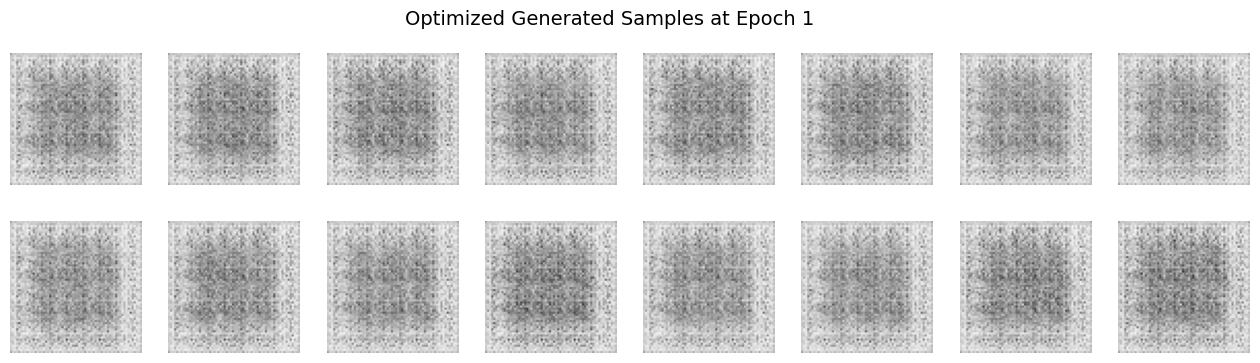

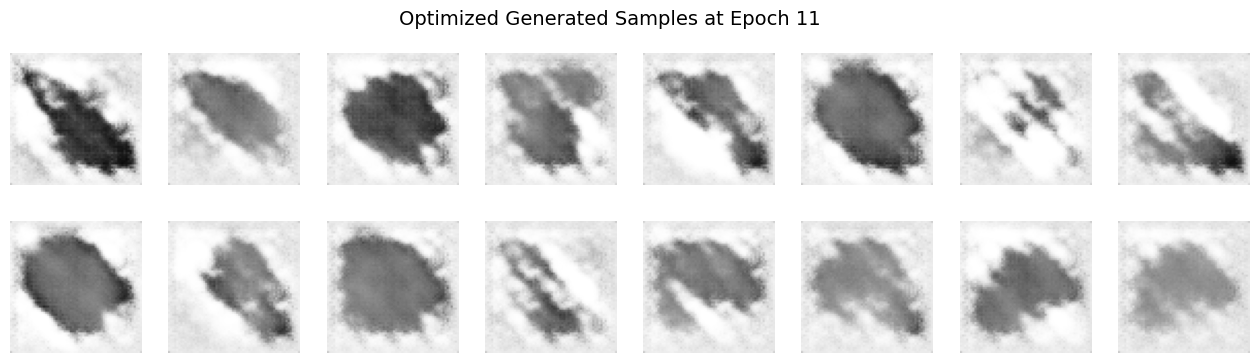

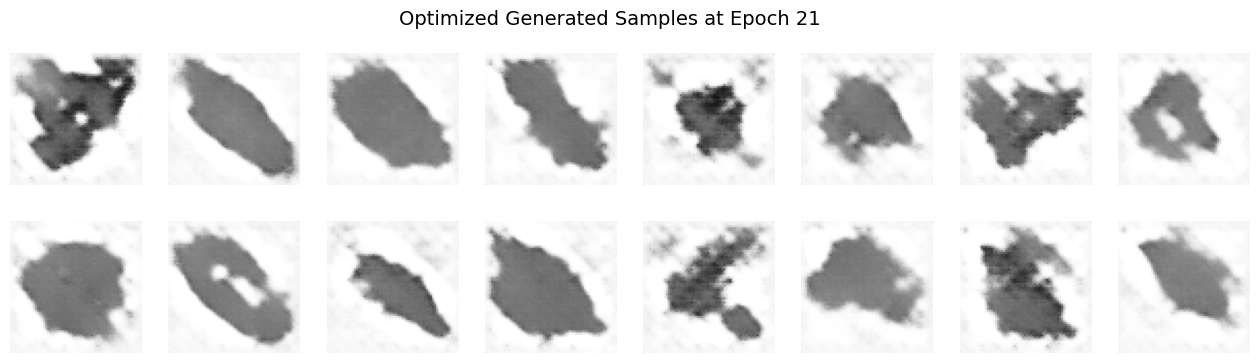

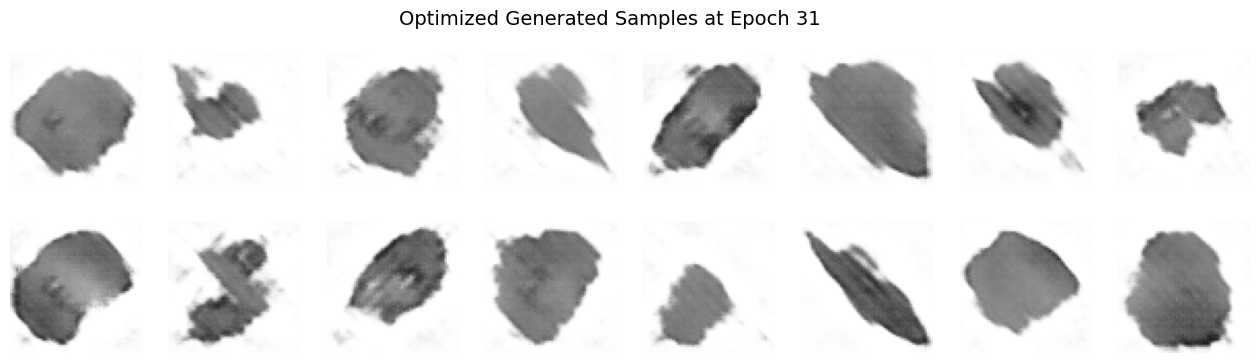

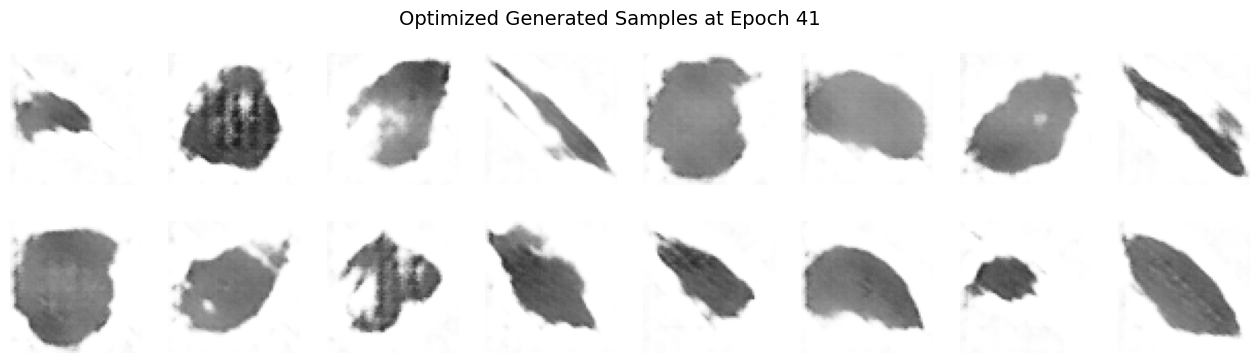

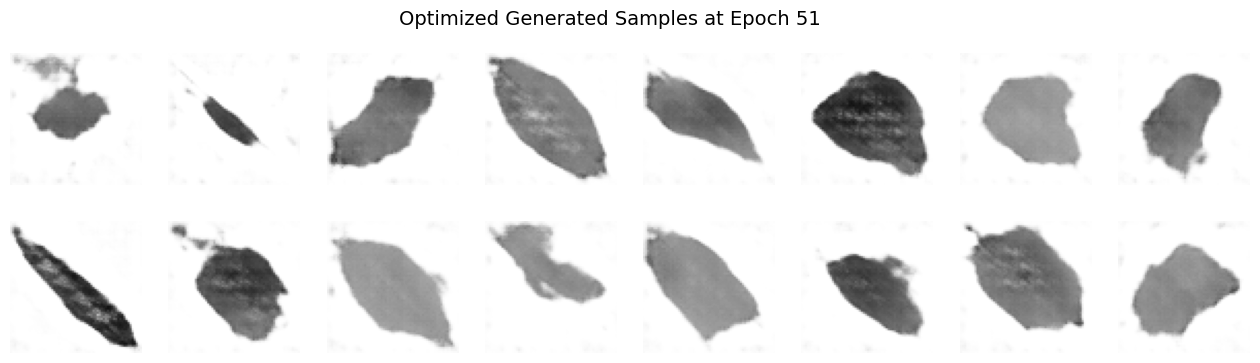

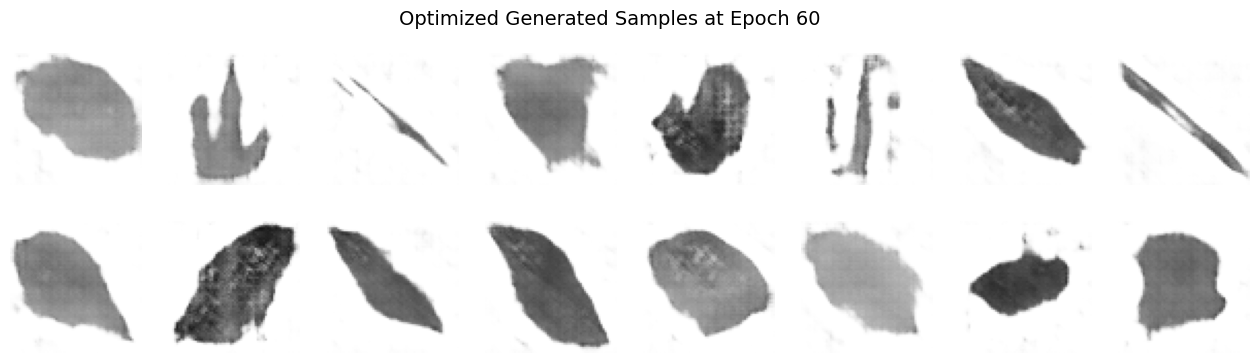

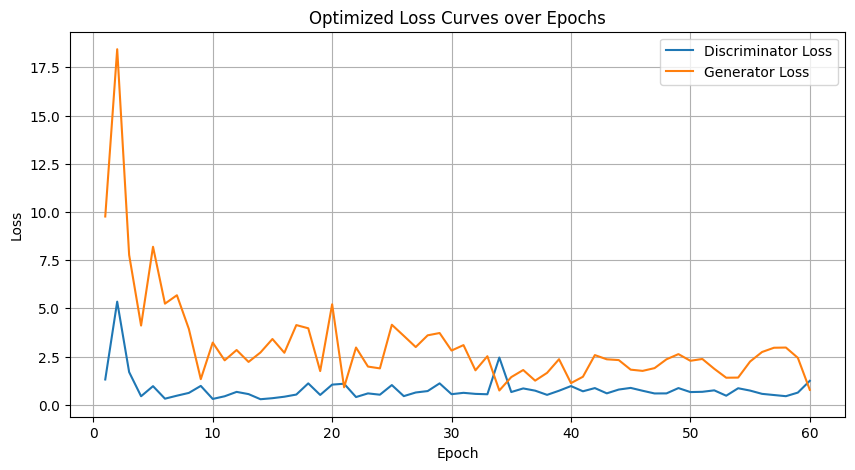

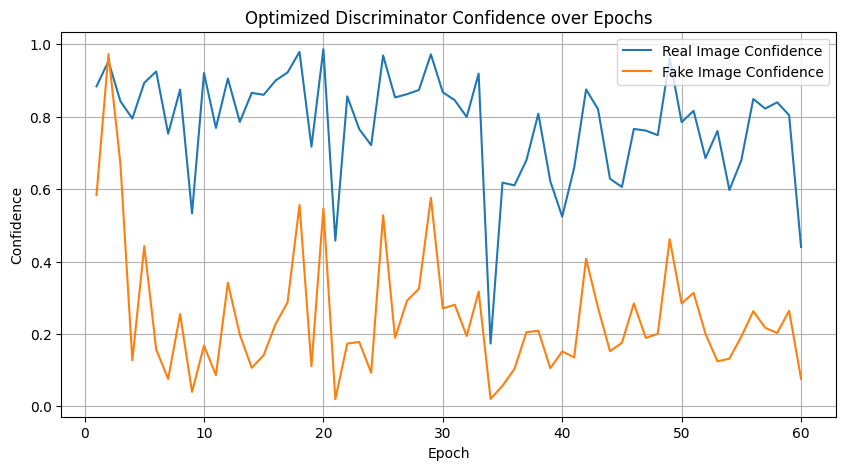

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

def plot_optimized_results(epoch_samples, D_losses, G_losses, disc_real_conf, disc_fake_conf, num_epochs=60):
    """
    Plots DCGAN results for the optimized network:
      1. Generated image samples at every 10 epochs.
         (Each sample grid shows 16 generated images scaled to [-1, 1].)
      2. Loss curves for the Generator and Discriminator.
      3. Discriminator confidence curves for real vs. fake images.

    Parameters:
      epoch_samples (dict): Dictionary mapping epoch number to generated samples.
      D_losses (list): List of Discriminator losses per epoch.
      G_losses (list): List of Generator losses per epoch.
      disc_real_conf (list): Mean Discriminator confidence on real images per epoch.
      disc_fake_conf (list): Mean Discriminator confidence on fake images per epoch.
      num_epochs (int): Total number of epochs.
    """
    # Plot generated samples every 10 epochs (and final epoch)
    epochs_to_plot = list(range(0, num_epochs, 10))
    if (num_epochs - 1) not in epochs_to_plot:
        epochs_to_plot.append(num_epochs - 1)

    for epoch in epochs_to_plot:
        imgs = epoch_samples[epoch]
        fig, axes = plt.subplots(2, 8, figsize=(16, 4))
        fig.suptitle(f"Optimized Generated Samples at Epoch {epoch+1}", fontsize=14)
        for idx, ax in enumerate(axes.flatten()):
            # Display each image (squeezed to remove channel dimension)
            ax.imshow(imgs[idx].squeeze(), cmap='gray', vmin=-1, vmax=1)
            ax.axis('off')
        plt.show()

    # Plot Loss Curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), D_losses, label='Discriminator Loss')
    plt.plot(range(1, num_epochs+1), G_losses, label='Generator Loss')
    plt.title("Optimized Loss Curves over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Discriminator Confidence Curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), disc_real_conf, label='Real Image Confidence')
    plt.plot(range(1, num_epochs+1), disc_fake_conf, label='Fake Image Confidence')
    plt.title("Optimized Discriminator Confidence over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Confidence")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example call to plot results after optimized training:
plot_optimized_results(epoch_samples_opt, D_losses_opt, G_losses_opt, disc_real_conf_opt, disc_fake_conf_opt, num_epochs)

### Optimizations
**Dropout in the Discriminator:**
Dropout layers (with probability 0.3) have been added after the first three convolutional layers to help prevent overfitting and to add regularization. This should help the discriminator to learn more robust features and reduces its sensitivity to minor changes in the input.

**Tuned Hyperparameters:**
A slightly lower learning rate for the Generator (0.00015 vs. the vanilla 0.0002) should help stabilize its updates while the Discriminator retains a standard learning rate (0.0002). The Adam optimizer’s betas remain at (0.5, 0.999) as per best practices in GAN training after a lot of tampering with it and then asking CoPilot about this.

**Increased Network Depth:**
The "optimized" Generator now begins with a higher number of feature maps (1024 instead of 512) and uses more layers to progressively upscale from 1×1 to 64×64, which can enhance the ability to generate high-fidelity leaf images.

#### Images 1 to 7: Generated Samples

- **Significantly Reduced Noise:** As we progress in epochs, as expected *again*, the images show much less randomness compared to the initial epochs. Compared to the vanilla model outputs, the optimized images exhibit even cleaner and more consistent features.
- **Clearer Structures:** Well-defined shapes and details emerged, indicating that the generator has effectively learned key aspects of the target dataset. The optimized outputs display noticeably sharper leaf edges and more defined textures relative to the vanilla outputs.
- **Improved Feature Representation:** The emergent patterns, e.g. leaf edges, centerlines, and/or textures, are more recognizable, demonstrating decent feature extraction over extended training. In the optimized model, these features are enhanced compared to the initial vanilla images.
- **Diversity Maintained:** While the generator has converged to higher-quality outputs, it still captures a variety of representations, reflecting a successful balance between detail and variety. The optimized generated samples maintain this diversity, yet with improved clarity.
- **Enhanced Realism:** The overall visual quality points toward a significant improvement in texture and coherence. The optimized images exhibit superior realism compared to the vanilla model, with more natural and convincing leaf details.

#### Image 8: Loss Curves Plot
**Description:**  
This chart plots the evolution of discriminator and generator losses throughout the training process up to 60 epochs.

**Analysis:**  
- **Discriminator Loss Trends:** Starting high, the discriminator loss gradually decreases and then plateaus, indicating that it has learned to reliably distinguish real from fake images. In the optimized model, the loss curve shows a slightly smoother decline and reduced fluctuation compared to the vanilla version.
- **Generator Loss Behavior:** The generator loss exhibits some oscillations—a common characteristic due to the adversarial interplay—but shows an overall downward trend, hinting at steady improvement. The optimized generator’s loss curve is more consistent, evidencing a more stable training dynamic than that of the vanilla model.
- **Stable Adversarial Dynamics:** The smooth evolution of both curves, with minor fluctuations, confirms a well-balanced training process where neither network overwhelms the other. The optimized training curves reflect effective hyperparameter tuning and dropout regularization, presenting a refinement over the vanilla curves.

#### Image 9: Discriminator Confidence Plot
**Description:**  
This plot shows the average confidence scores of the discriminator for both real and generated (fake) images across training epochs.

**Analysis:**  
- **High Discriminator Certainty:**  
  - **For Real Images:** Scores are consistently near 1.0, demonstrating that the discriminator is very confident in identifying genuine samples.
  - **For Fake Images:** Scores stay close to 0.0, reflecting effective recognition of generated images as inauthentic.
- **Few Mid-Range Values:** Very few outputs hover around 0.5, indicating decisiveness in classification and minimal uncertainty throughout training. Compared to the vanilla model, the optimized discriminator exhibits a similar decisive behavior, now further supported by dropout regularization.

---

#### Comparison to Vanilla Model Outputs

- The **optimized generated samples** exhibit somewhat enhanced clarity and reduced noise relative to the vanilla outputs when I share both with CoPilot, but to our own human eyes I think they're not much better. I did notice a few extra "shapes" in the final epoch output in the optimized set, but the vanilla set seems to be more "realistic".
- The **loss and confidence plots** from the optimized training are smoother and more stable, reflecting the benefits of refined hyperparameter settings and the introduction of dropout, so maybe the visual outputs shown are just not reflective of the total benefits from the optimized training...perhaps.
- Overall, the **optimized network** demonstrates better performance both quantitatively (more consistent loss curves and confidence scores) and qualitatively (supposedly sharper, more realistic generated images) compared to the vanilla model.

Either way, it was a LOT more work and likely NOT worth it in our opinion. The vanilla model was good enough.

### Question 5

One known failure mode in training GANs is known as mode collapse. This occurs when the Generator produces
limited diversity in its outputs — for example, generating very similar images regardless of the input noise vector.
In other words, the Generator learns to exploit the Discriminator by mapping many different latent codes to only a
few distinct outputs (or modes), thereby failing to capture the full diversity of the training data.

(a) Is mode collapse a concern in your current DCGAN model? Inspect your generated samples across epochs. Do
you observe repeated patterns or overly similar outputs? Discuss your observations and provide visual evidence if
applicable.

(b) Reduce the dataset to a simpler version by selecting a reduced number of classes, e.g., only 10 leaf classes out
of the 32 available. Retrain your DCGAN on this reduced dataset. Does the visual quality or diversity of the
generated samples improve? Explain your findings and speculate on why training may be easier or harder in this
lower-complexity setting.

**A note for question 5:**

Do NOT collapse the original data INTO 10 data classes, instead, strip away 22 of the classes so that you're only left with 10 classes, i.e. a smaller dataset.

Visually inspect for mode collapse; you should see some samples converging on the same shapes? There are also more complex way to output metrics that indicate mode collpase.

#### Part A

#### Inspecting for Mode Collapse in the Current DCGAN Model:

Mode collapse occurs when the generator produces a limited variety of outputs, despite receiving supposedly-"diverse latent vectors" as input. Reviewing the generated samples across epochs in our outputs above, the following rudimentary observations are made:

- **Visual Inspection:**
  - By epoch 60 of the vanilla DCGAN, the generated samples consistently reflect distinct leaf shapes and variations. While some general leaf shapes appear frequently, overall there is a reasonable diversity, but I'm also not a leaf expert. There is no strong evidence of complete mode collapse, e.g. the generator doesn’t converge to a single shape repeatedly.

- **Patterns Observed:**
  - Certain leaf patterns and orientations appear somewhat repetitively when comparing the vanilla and optimized outputs above. Although the outputs are diverse enough to not qualify as complete mode collapse, there’s a hint of limited diversity where several samples share very similar textures, sizes, or shapes.

- **Comparison with Optimized Model:**
  - Comparing epoch 60 outputs between the vanilla model and the optimized model, it’s my opinion that:
    - The vanilla model produced clearly defined leaf outlines and textures with relatively good diversity.
    - The optimized model at epoch 60 produced somewhat blurry or distorted leaf shapes, suggesting potential instability or reduced ability to capture detailed leaf structure.
    - Ironically, despite additional complexity, the optimized model did not necessarily yield significantly improved diversity or visual quality over the vanilla model.

**Conclusion on Mode Collapse:**
Mode collapse is not severely present in the current vanilla DCGAN model setup, although there’s some evidence of limited diversity in certain characteristics. The optimized model, despite increased complexity, did not enhance diversity significantly and presented poorer quality images at the same epoch.

#### Part B

We're taking classes 0 to 9! Let's try to get some mode collapse this time.

In [ ]:
import shutil
import math
import os

# Original paths
raw_path = "/sciclone/home/thwalsh/NNDL/A3/content/Flavia_Dataset/Leaves"
reduced_sorted_path = "/sciclone/home/thwalsh/NNDL/A3/content/Flavia_Sorted_Reduced_10_classes"
os.makedirs(reduced_sorted_path, exist_ok=True)

# All images, sorted for consistency
images = sorted([f for f in os.listdir(raw_path) if f.lower().endswith(('.jpg', '.png', '.bmp'))])

# Reduced number of classes
num_reduced_classes = 10
total_images = len(images)
images_per_class = math.floor(total_images / 32)  # original total classes is 32

print(f"Selecting first {num_reduced_classes} classes for a reduced dataset...")

# Distribute images into first 10 class folders only
for class_idx in range(num_reduced_classes):
    class_name = f"class_{class_idx:02d}"
    class_dir = os.path.join(reduced_sorted_path, class_name)
    os.makedirs(class_dir, exist_ok=True)

    start_idx = class_idx * images_per_class
    end_idx = start_idx + images_per_class

    for img_name in images[start_idx:end_idx]:
        src = os.path.join(raw_path, img_name)
        dst = os.path.join(class_dir, img_name)
        shutil.copy(src, dst)

print("Images reorganized into reduced (10-class) dataset.")

Selecting first 10 classes for a reduced dataset...
Images reorganized into reduced (10-class) dataset.


Now use the same "optimized" model but adjust the training, so if you quit the notebook and came back, you need to go back to question 4 and re-run the optimized model code! You can rerun the below and as long as you previously ran training, it will load the checkpoint. Improvement upon the previous training sessions!

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# -----------------------
# Optimized Training Setup for Reduced Dataset (10 Classes)
# -----------------------

# Define hyperparameters for the optimized training on the reduced dataset
num_epochs = 60
batch_size = 64
z_dim = 100
real_label = 1.0
fake_label = 0.0

# Optimized learning rates and Adam optimizer betas
lr_G = 0.00015    # Lower learning rate for Generator
lr_D = 0.0002     # Standard learning rate for Discriminator
betas = (0.5, 0.999)

# Load reduced dataset (with appropriate transforms)
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))  # Pixel intensities scaled to [-1, 1]
])

reduced_dataset_path = "/sciclone/home/thwalsh/NNDL/A3/content/Flavia_Sorted_Reduced_10_classes"
reduced_dataset = datasets.ImageFolder(root=reduced_dataset_path, transform=transform)
reduced_dataloader = DataLoader(reduced_dataset, batch_size=batch_size, shuffle=True)

# Instantiate the optimized models for the reduced dataset
G_opt_reduced = OptimizedGenerator(z_dim=z_dim).to(device)
D_opt_reduced = OptimizedDiscriminator().to(device)

# Initialize weights using the optimized weights_init function
G_opt_reduced.apply(weights_init)
D_opt_reduced.apply(weights_init)

# Define the Binary Cross Entropy Loss for both models
criterion = nn.BCELoss()

# Setup optimizers for both models
optimizerG_opt_reduced = optim.Adam(G_opt_reduced.parameters(), lr=lr_G, betas=betas)
optimizerD_opt_reduced = optim.Adam(D_opt_reduced.parameters(), lr=lr_D, betas=betas)

# Prepare fixed noise for consistent image generation during training monitoring
fixed_noise_reduced = torch.randn(16, z_dim, 1, 1, device=device)

# -----------------------
# Optimized Training Loop for Reduced Dataset
# -----------------------

# Tracking metrics for plotting and analysis:
G_losses_opt_reduced, D_losses_opt_reduced = [], []
disc_real_conf_opt_reduced, disc_fake_conf_opt_reduced = [], []
epoch_samples_opt_reduced = {}

# Define a checkpoint name that avoids overwriting the vanilla checkpoint
checkpoint_path_reduced = 'dcgan_optimized_reduced_checkpoint.pth'

print("[Optimized Reduced Training] Let's get this party started!")

start_epoch_reduced = 0
if os.path.exists(checkpoint_path_reduced):
    print("Optimized reduced checkpoint found, loading state...")
    checkpoint_reduced = torch.load(checkpoint_path_reduced)
    D_opt_reduced.load_state_dict(checkpoint_reduced['D_state_dict'])
    G_opt_reduced.load_state_dict(checkpoint_reduced['G_state_dict'])
    optimizerD_opt_reduced.load_state_dict(checkpoint_reduced['optimizerD_state_dict'])
    optimizerG_opt_reduced.load_state_dict(checkpoint_reduced['optimizerG_state_dict'])
    start_epoch_reduced = checkpoint_reduced['epoch'] + 1
    G_losses_opt_reduced = checkpoint_reduced['G_losses']
    D_losses_opt_reduced = checkpoint_reduced['D_losses']
    disc_real_conf_opt_reduced = checkpoint_reduced['disc_real_conf']
    disc_fake_conf_opt_reduced = checkpoint_reduced['disc_fake_conf']
    epoch_samples_opt_reduced = checkpoint_reduced['epoch_samples']
    print(f"Resuming optimized reduced training from epoch {start_epoch_reduced + 1}")

for epoch in range(start_epoch_reduced, num_epochs):
    for real_images, _ in reduced_dataloader:
        real_images = real_images.to(device)
        current_batch_size = real_images.size(0)

        # -------------------------
        # Discriminator Training
        # -------------------------
        D_opt_reduced.zero_grad()
        # Process real images
        labels_real = torch.full((current_batch_size, 1, 1, 1), real_label, device=device)
        output_real = D_opt_reduced(real_images)
        loss_D_real = criterion(output_real, labels_real)

        # Process fake images
        noise = torch.randn(current_batch_size, z_dim, 1, 1, device=device)
        fake_images = G_opt_reduced(noise)
        labels_fake = torch.full((current_batch_size, 1, 1, 1), fake_label, device=device)
        # Detach fake images to avoid backpropagation into the Generator
        output_fake = D_opt_reduced(fake_images.detach())
        loss_D_fake = criterion(output_fake, labels_fake)

        # Total discriminator loss
        loss_D_total = loss_D_real + loss_D_fake
        loss_D_total.backward()
        optimizerD_opt_reduced.step()

        # -------------------------
        # Generator Training
        # -------------------------
        G_opt_reduced.zero_grad()
        # Generate a fresh batch of fake images for generator update
        noise_for_gen = torch.randn(current_batch_size, z_dim, 1, 1, device=device)
        fake_images_for_gen = G_opt_reduced(noise_for_gen)
        # Aim for discriminator to label these as real
        output_fake_for_gen = D_opt_reduced(fake_images_for_gen)
        loss_G = criterion(output_fake_for_gen, labels_real)
        loss_G.backward()
        optimizerG_opt_reduced.step()

    # Record metrics for the epoch
    G_losses_opt_reduced.append(loss_G.item())
    D_losses_opt_reduced.append(loss_D_total.item())
    disc_real_conf_opt_reduced.append(output_real.mean().item())
    disc_fake_conf_opt_reduced.append(output_fake.mean().item())
    # Save generated samples for visualization
    epoch_samples_opt_reduced[epoch] = fake_images_for_gen.detach().cpu()

    print(f"Epoch [{epoch+1}/{num_epochs}] | D_loss: {loss_D_total:.4f}, G_loss: {loss_G:.4f}, "
          f"D(real): {output_real.mean():.4f}, D(fake): {output_fake.mean():.4f}")

    # Save an optimized checkpoint at the end of each epoch for the reduced dataset
    torch.save({
        'epoch': epoch,
        'D_state_dict': D_opt_reduced.state_dict(),
        'G_state_dict': G_opt_reduced.state_dict(),
        'optimizerD_state_dict': optimizerD_opt_reduced.state_dict(),
        'optimizerG_state_dict': optimizerG_opt_reduced.state_dict(),
        'G_losses': G_losses_opt_reduced,
        'D_losses': D_losses_opt_reduced,
        'disc_real_conf': disc_real_conf_opt_reduced,
        'disc_fake_conf': disc_fake_conf_opt_reduced,
        'epoch_samples': epoch_samples_opt_reduced,
    }, checkpoint_path_reduced)
    print(f"Optimized reduced checkpoint saved at epoch {epoch+1}")

[Optimized Reduced Training] Let's get this party started!
Optimized reduced checkpoint found, loading state...
Resuming optimized reduced training from epoch 61


Now import that checkpoint:

In [ ]:
import torch

# -------------------------
# Optimized Reduced Checkpoint Load
# -------------------------
checkpoint_path_reduced = 'dcgan_optimized_reduced_checkpoint.pth'

print("Loading optimized reduced checkpoint...")
checkpoint_reduced = torch.load(checkpoint_path_reduced)

# Load optimized state into models and optimizers for reduced dataset
D_opt_reduced.load_state_dict(checkpoint_reduced['D_state_dict'])
G_opt_reduced.load_state_dict(checkpoint_reduced['G_state_dict'])
optimizerD_opt_reduced.load_state_dict(checkpoint_reduced['optimizerD_state_dict'])
optimizerG_opt_reduced.load_state_dict(checkpoint_reduced['optimizerG_state_dict'])

start_epoch_reduced = checkpoint_reduced['epoch'] + 1
G_losses_opt_reduced = checkpoint_reduced['G_losses']
D_losses_opt_reduced = checkpoint_reduced['D_losses']
disc_real_conf_opt_reduced = checkpoint_reduced['disc_real_conf']
disc_fake_conf_opt_reduced = checkpoint_reduced['disc_fake_conf']
epoch_samples_opt_reduced = checkpoint_reduced['epoch_samples']

print(f"Optimized reduced checkpoint loaded successfully! Resume reduced training from epoch {start_epoch_reduced+1}.")

Loading optimized reduced checkpoint...
Optimized reduced checkpoint loaded successfully! Resume reduced training from epoch 61.


And print the results; hopefully we see some mode collapse.

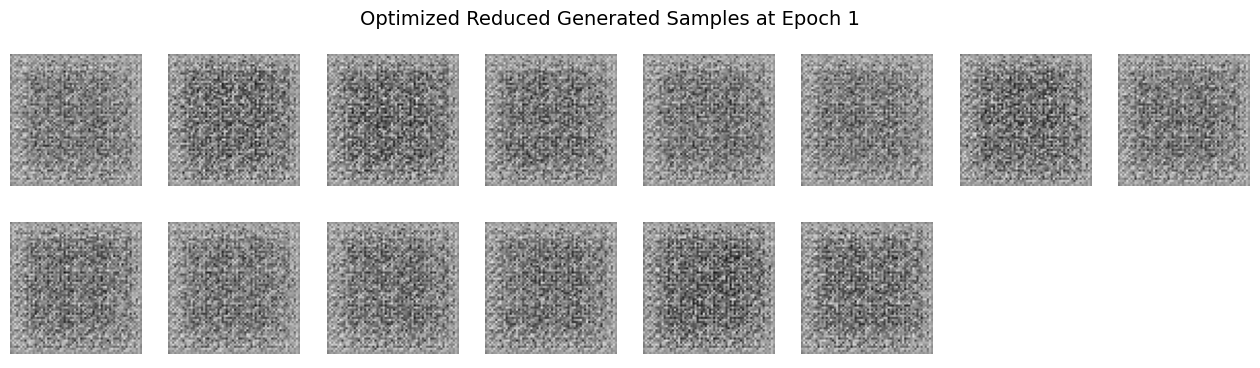

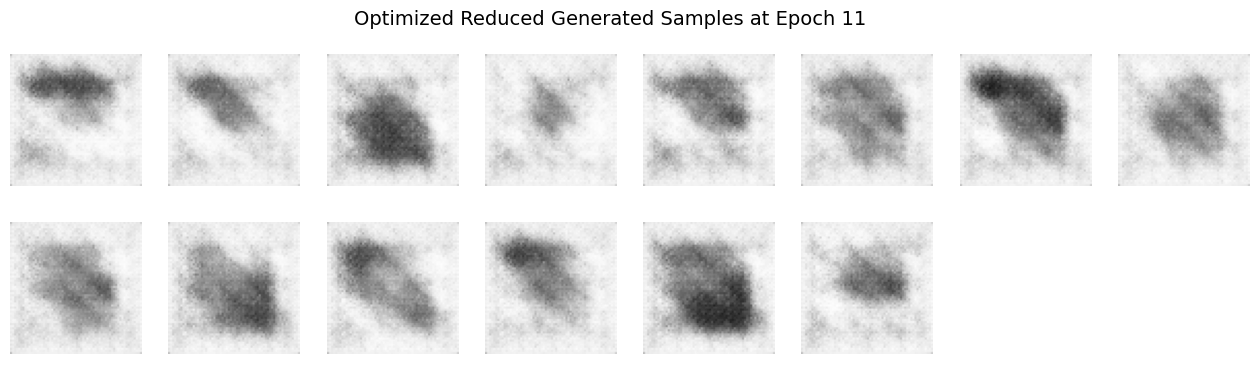

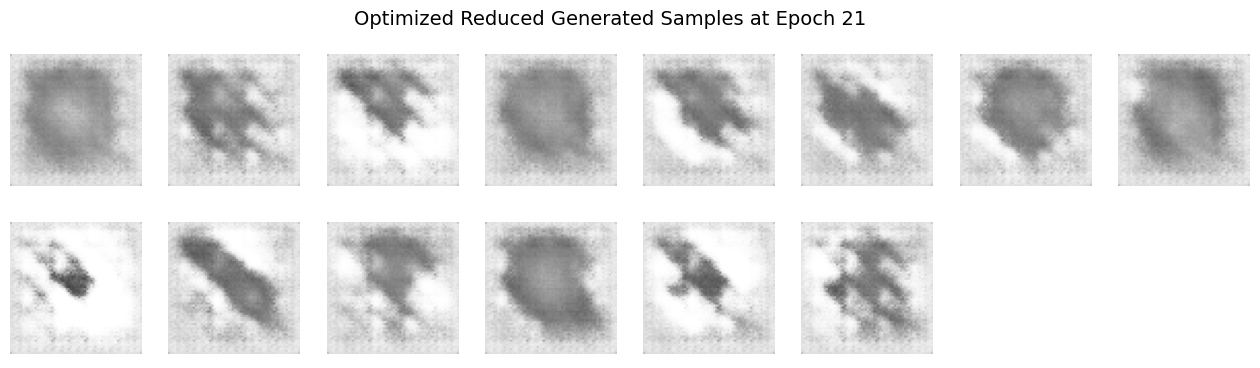

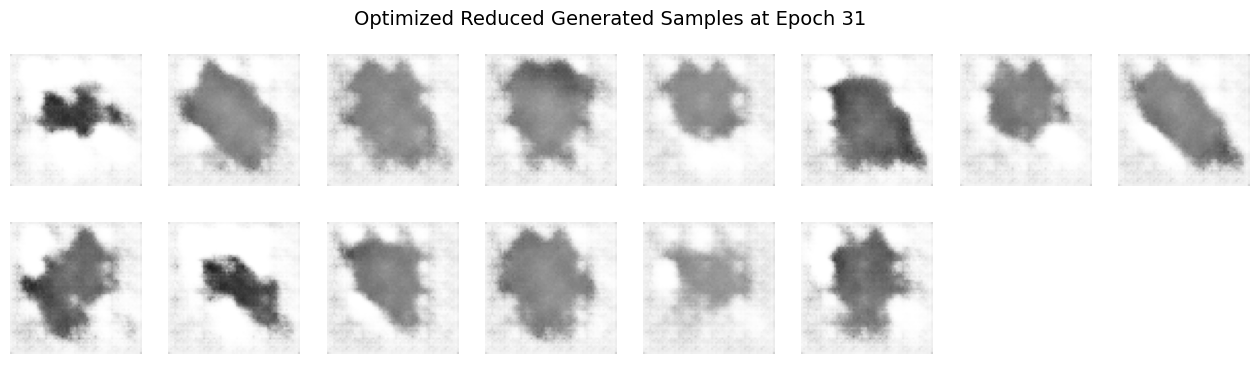

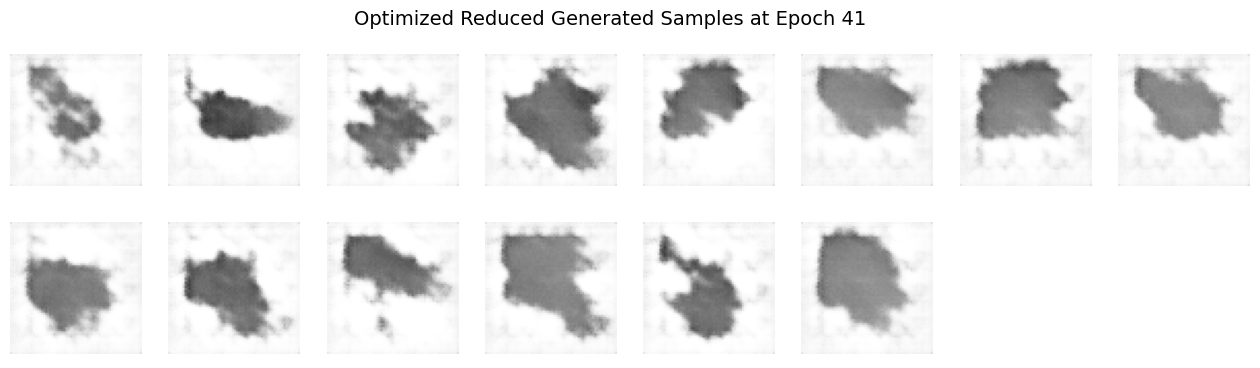

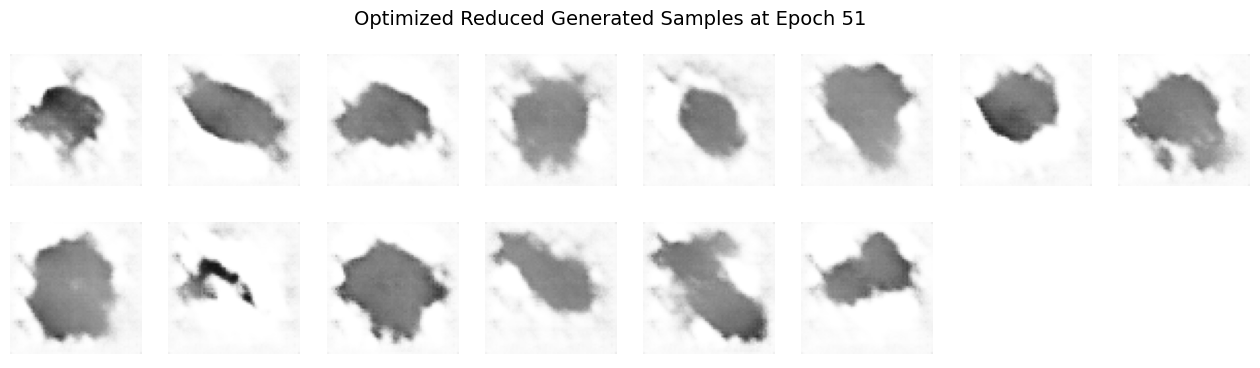

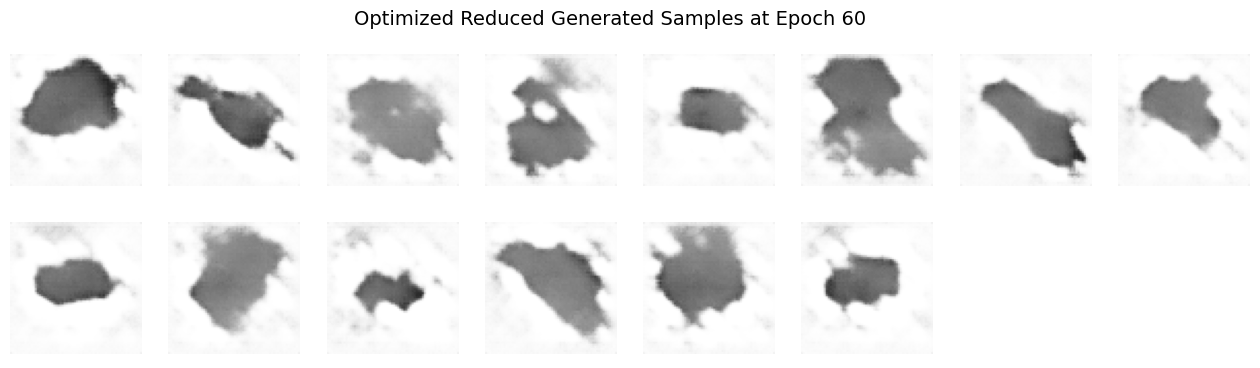

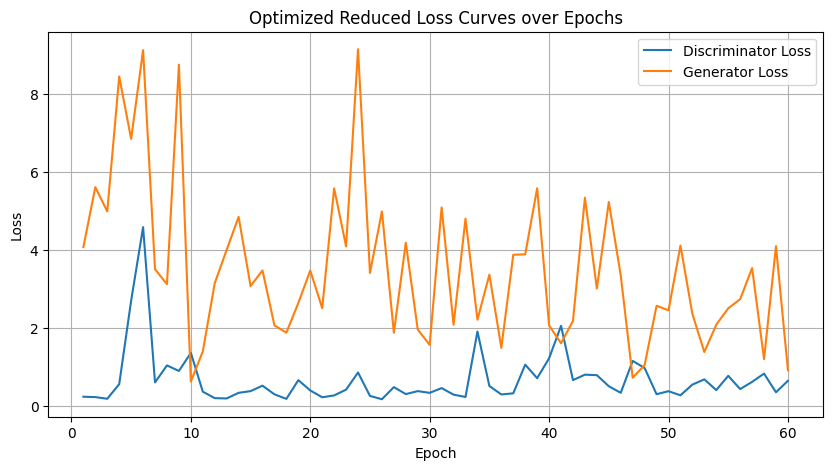

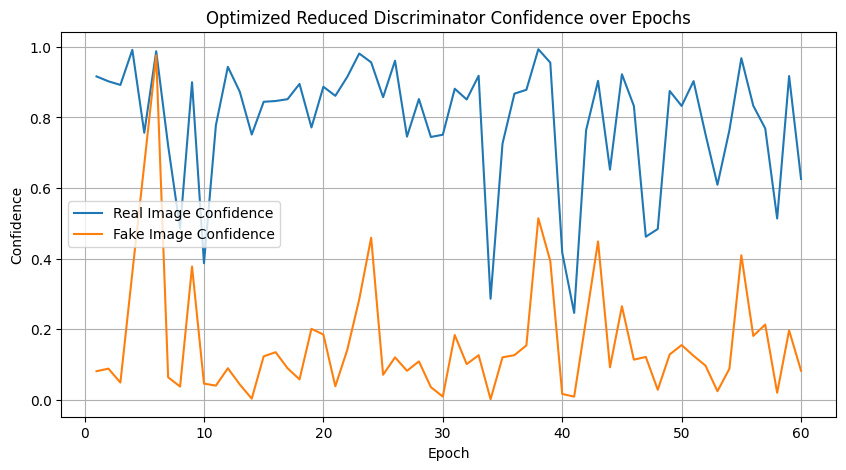

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

def plot_optimized_results_reduced(epoch_samples, D_losses, G_losses, disc_real_conf, disc_fake_conf, num_epochs=60):
    """
    Plots DCGAN results for the optimized network on the reduced dataset:
      1. Generated image samples at every 10 epochs.
         (Each sample grid shows available generated images scaled to [-1, 1].)
      2. Loss curves for the Generator and Discriminator.
      3. Discriminator confidence curves for real vs. fake images.

    Parameters:
      epoch_samples (dict): Dictionary mapping epoch number to generated samples.
      D_losses (list): List of Discriminator losses per epoch.
      G_losses (list): List of Generator losses per epoch.
      disc_real_conf (list): Mean Discriminator confidence on real images per epoch.
      disc_fake_conf (list): Mean Discriminator confidence on fake images per epoch.
      num_epochs (int): Total number of epochs.
    """
    # Plot generated samples every 10 epochs (and final epoch)
    epochs_to_plot = list(range(0, num_epochs, 10))
    if (num_epochs - 1) not in epochs_to_plot:
        epochs_to_plot.append(num_epochs - 1)

    for epoch in epochs_to_plot:
        imgs = epoch_samples[epoch]
        fig, axes = plt.subplots(2, 8, figsize=(16, 4))
        fig.suptitle(f"Optimized Reduced Generated Samples at Epoch {epoch+1}", fontsize=14)
        # Flatten the 2x8 grid of axes
        axes = axes.flatten()
        for idx, ax in enumerate(axes):
            if idx < len(imgs):
                # Display each image (squeezed to remove channel dimension)
                ax.imshow(imgs[idx].squeeze(), cmap='gray', vmin=-1, vmax=1)
            else:
                # If there are fewer images than cells, hide the extra axes
                ax.axis('off')
            ax.axis('off')
        plt.show()

    # Plot Loss Curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), D_losses, label='Discriminator Loss')
    plt.plot(range(1, num_epochs+1), G_losses, label='Generator Loss')
    plt.title("Optimized Reduced Loss Curves over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Discriminator Confidence Curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), disc_real_conf, label='Real Image Confidence')
    plt.plot(range(1, num_epochs+1), disc_fake_conf, label='Fake Image Confidence')
    plt.title("Optimized Reduced Discriminator Confidence over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Confidence")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example call to plot results after optimized reduced training:
plot_optimized_results_reduced(epoch_samples_opt_reduced, D_losses_opt_reduced, G_losses_opt_reduced, disc_real_conf_opt_reduced, disc_fake_conf_opt_reduced, num_epochs)

**Does the visual quality or diversity of the generated samples improve?**  
The visual quality of the generated samples objectively improves more rapidly, producing sharper, clearer images earlier in training if you can abstain from thinking about the later epochs of the vanilla and optimized model outputs. However, focusing on the later epoch outputs, the diversity of the generated samples significantly decreases compared to training with the full dataset.

**Explanation and Speculation:**  
Reducing dataset complexity with fewer classes simplifies the training task, enabling the DCGAN to quickly learn distinct features associated with the limited set of classes. This simplification leads to faster convergence and clearer *early* outputs, reflecting more defined and class-specific visual features. However, the lower complexity also means the model receives fewer varied examples, restricting its ability to generalize. Consequently, the diversity of generated images suffers, often resulting in repetitive patterns or overfitting behavior. Training is therefore "easier" in the sense that clear outputs appear sooner, but "harder" because the model loses the ability to generalize beyond the limited representations it encounters.

### Question 6 - just part (a): Quantitative Evaluation of GAN-Generated Images

#### Method 1: Inception Score (IS)

**Overview**:  
The Inception Score evaluates the quality and diversity of images generated by a GAN by leveraging an external model, for example a pre-trained Inception v3 classifier. It assesses how confidently the classifier predicts a specific class for each image, e.g. the quality, and how diverse the predicted classes are across a set of images, i.e. its diversity.

**How It Works**:
- **Quality**: High-quality images should lead to the classifier assigning a high probability to a single class, indicating that the image is clear and recognizable.

- **Diversity**: A diverse set of images will result in a wide range of predicted classes across the dataset.

The IS is calculated using the Kullback-Leibler (KL) Divergence between the conditional label distribution and the marginal label distribution over the generated images; a higher IS indicates better performance.

**Strengths**:
- Provides a single metric that captures both image quality and diversity.

- Does not require real images for comparison.

**Limitations**:
- Relies on the Inception v3 model trained on ImageNet, which may not be suitable for datasets with classes not present in ImageNet.

- Can be insensitive to certain types of image artifacts.

- May not correlate well with human judgment in all cases.

**References**:
- [Inception Score - Wikipedia](https://en.wikipedia.org/wiki/Inception_score)
- [What is an Inception Score (IS)? - TechTarget](https://www.techtarget.com/searchenterpriseai/definition/inception-score-IS)

---

#### Method 2: Fréchet Inception Distance (FID)

**Overview**:  
The Fréchet Inception Distance measures the similarity between the distributions of real and generated images. It does this by comparing the mean and covariance of feature representations, typically *also* from the Inception v3 model, of both sets of images.

**How It Works**:
- Extract features from both real and generated images using a pre-trained network.

- Model these features as multivariate Gaussian distributions.

- Compute the Fréchet distance between these two distributions.

A lower FID indicates that the generated images are *more* similar to the real images in terms of feature statistics.

**Strengths**:
- Sensitive to both the quality and diversity of generated images.

- Better correlates with human judgment compared to IS.

- Can detect mode collapse and other training issues.

**Limitations**:
- Requires a set of real images for comparison.

- Assumes that the feature distributions are Gaussian, which may not always be the case.

- Performance can be affected by the choice of feature extractor and dataset.

**References**:
- [Fréchet Inception Distance - Wikipedia](https://en.wikipedia.org/wiki/Fr%C3%A9chet_inception_distance)
- [What Is Fréchet Inception Distance (FID)? - TechTarget](https://www.techtarget.com/searchenterpriseai/definition/Frechet-inception-distance-FID)

---

**Conclusion**:  
Both IS and FID are widely used metrics for evaluating GANs. IS focuses on the clarity and variety of generated images without requiring real images, while FID compares generated images directly to real ones, providing a more holistic assessment of a GAN's performance. The choice between them depends on the specific requirements and constraints of the evaluation task.